## The Circuit <a id="circuit"></a>

We now implement the Bernstein-Vazirani algorithm with Qiskit by first preparing the environment.

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.compiler import transpile
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

We first set the number of qubits used in the experiment, and the hidden integer $a$ to be found by the Bernstein-Vazirani algorithm. The hidden integer $a$ determines the circuit for the quantum oracle. 

In [2]:
nQubits = 4 # number of physical qubits
a = 11 #DECIMAL----the hidden integer whose bitstring is 1011 in BINARY

# make sure that a can be represented with nQubits
a = a % 2**(nQubits)

We then use Qiskit to program the Bernstein-Vazirani algorithm.

In [3]:
# Creating registers
# qubits for querying the oracle and finding the hidden integer
qr = QuantumRegister(nQubits)
# for recording the measurement on qr
cr = ClassicalRegister(nQubits)

circuitName = "BernsteinVazirani"
bvCircuit = QuantumCircuit(qr, cr)

# Apply Hadamard gates before querying the oracle
for i in range(nQubits):
    bvCircuit.h(qr[i])
    
# Apply barrier so that it is not optimized by the compiler
bvCircuit.barrier()

# Apply the inner-product oracle
for i in range(nQubits):
    if (a & (1 << i)):
        bvCircuit.z(qr[i])
    else:
        bvCircuit.id(qr[i])
        
# Apply barrier 
bvCircuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(nQubits):
    bvCircuit.h(qr[i])
    
# Measurement
bvCircuit.barrier(qr)
bvCircuit.measure(qr, cr)

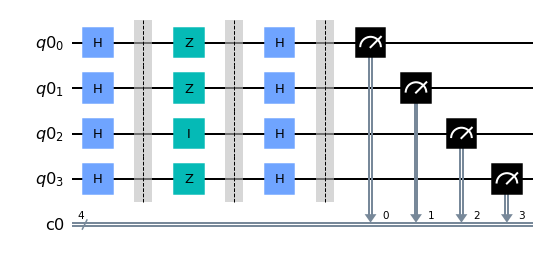

In [4]:
bvCircuit.draw(output='mpl')

## Experiment with Simulators

We can run the above circuit on the simulator. 

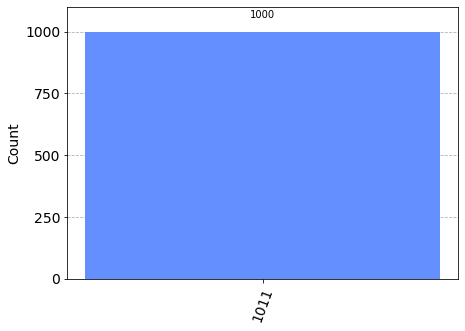

In [5]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1000
results = execute(bvCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

We can see that the result of the measurement is the binary representation of the hidden integer $a$. 

## Experiment with Real Devices

We can run the circuit on the real device as below.

In [6]:
from qiskit import IBMQ
IBMQ.save_account('87e81a3de8a45f8a9ee4b2ccdb65b7b1d60dceec51f8541ac31f74fcec029dc63ec26a70a3d6ee88184bfe4719aa82eed0eca8a396e364c28b727ea8f42c4ec3', overwrite=True)


In [7]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [8]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [9]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [10]:
backend = provider.get_backend('ibm_oslo')

In [ ]:
shots = 1000

bvCompiled = transpile(bvCircuit, backend=backend, optimization_level=1)
job_exp = execute(bvCircuit, backend=backend, shots=shots)    
job_monitor(job_exp)

In [ ]:
results = job_exp.result()
answer = results.get_counts(bvCircuit)

threshold = int(0.01 * shots) #the threshold of plotting significant measurements
filteredAnswer = {k: v for k,v in answer.items() if v >= threshold} #filter the answer for better view of plots

removedCounts = np.sum([ v for k,v in answer.items() if v < threshold ]) #number of counts removed 
filteredAnswer['other_bitstrings'] = removedCounts  #the removed counts is assigned to a new index

plot_histogram(filteredAnswer)

In [ ]:
print(filteredAnswer)

In [ ]:
#-----unable to run on actual IBMQ device-----